Wczytywanie danych

In [1]:
import pandas as pd

In [2]:
orginal_data = pd.read_csv("data.csv")
orginal_data = orginal_data.drop('Volume', axis=1)
orginal_data['Date'] = pd.to_datetime(orginal_data['Date'])
orginal_data.set_index("Date", inplace=True)
orginal_data.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997


In [3]:
inflation_data = pd.read_csv("US_inflation_rates.csv")
inflation_data['date'] = pd.to_datetime(inflation_data['date'])
inflation_data.set_index("date", inplace=True)
inflation_data.rename(columns={"value":"inflation"}, inplace=True)
inflation_data.head()

,inflation
date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


Dodawanie cech:
*1.* Średniej
*2.* Odchyleń
*3.* Sredniej kroczącej

In [4]:
week = 5
month = 21
year = 251

def add_original_featue(df, df_new):
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)

def add_avg_price(df, df_new):
    df_new['avg_price_5']   = df['Close'].rolling(week).mean().shift(1)
    df_new['avg_price_30']  = df['Close'].rolling(month).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(year).mean().shift(1)
    df_new['ratio_avg_price_5_30']   = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365']  = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']

def add_std_price(df, df_new):
    df_new['std_price_5'] = df['Close'].rolling(week).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(month).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(year).std().shift(1)
    df_new['ratio_std_price_5_30']   = df_new['std_price_5']  / df_new['std_price_30']
    df_new['ratio_std_price_5_365']  = df_new['std_price_5']  / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']

def add_return(df, df_new):
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1).shift(1))
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(week)) / df['Close'].shift(week).shift(1))
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(month)) / df['Close'].shift(month).shift(1))
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(year)) / df['Close'].shift(year).shift(1))
    df_new['moving_avg_5'] = df_new['return_1'].rolling(week).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(month).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(year).mean().shift(1)

In [5]:
def generate_features(df):
    df_new = pd.DataFrame()
    add_original_featue(df, df_new)
    add_avg_price(df, df_new)
    add_std_price(df, df_new)
    add_return(df, df_new)
    df_new['close'] = df["Close"]
    df_new.dropna(axis=0)
    return df_new

In [6]:
data = generate_features(orginal_data)
inflation_data = inflation_data.resample('D').ffill()
data = data.join(inflation_data, how='left')

Preprocesing danych

In [7]:
start_train = '1973-01-01'
end_train = '2019-12-31'
start_test = '2020-01-01'
end_test = '2023-06-01'

data = data.loc[start_train:end_test]

data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values


data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values



In [8]:
X_train.shape, y_train.shape

((11855, 23), (11855,))

In [9]:
X_test.shape, y_test.shape

((860, 23), (860,))

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [11]:
import numpy as np
SEQ_LENGTH = month

def create_sequences(X, y, seq_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - seq_length):
        sequences_X.append(X[i:i+seq_length])
        sequences_y.append(y[i+seq_length])
    return np.array(sequences_X), np.array(sequences_y)

X_train_seq, y_train_seq = create_sequences(X_scaled_train, y_train, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_scaled_test, y_test, SEQ_LENGTH)

Wybór modelu

In [12]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        
        model.add(LSTM(
            units=hp.Int('units_1', min_value=32, max_value=256, step=32),
            activation='relu',
            return_sequences=True,
            input_shape=(SEQ_LENGTH, X_train_seq.shape[2])
        ))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(
                units=hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
                activation='relu',
                return_sequences=(i != hp.Int('num_layers', 1, 3) - 1)
            ))
            model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
        
        model.add(Dense(1))
        
        optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        elif optimizer_choice == 'rmsprop':
            optimizer = RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        else:
            optimizer = SGD(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model



/Users/tomaszkoczar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [64]:
import tensorflow as tf

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=25,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tuning'
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
tuner.search(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=50, callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model.keras')
best_model.summary()

Trial 25 Complete [00h 00m 19s]
val_loss: nan

Best val_loss So Far: 402312.6875
Total elapsed time: 23h 50m 11s


/Users/tomaszkoczar/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 96)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,409 (630.50 KB)

 Trainable params: 161,409 (630.50 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_seq, best_model.predict(X_test_seq))
print("R2:", r2)

mae = mean_absolute_error(y_test_seq, best_model.predict(X_test_seq))
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_seq, best_model.predict(X_test_seq))
print("Mean Squared Error:", mse)

val_loss = best_model.evaluate(X_test_seq, y_test_seq)
print(f'Validation loss: {val_loss}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R2: 0.8958069382781523
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Absolute Error: 487.0912433912768
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error: 402312.68886148813
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 378785.5625
Validation loss: 402312.6875


Wyniki

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


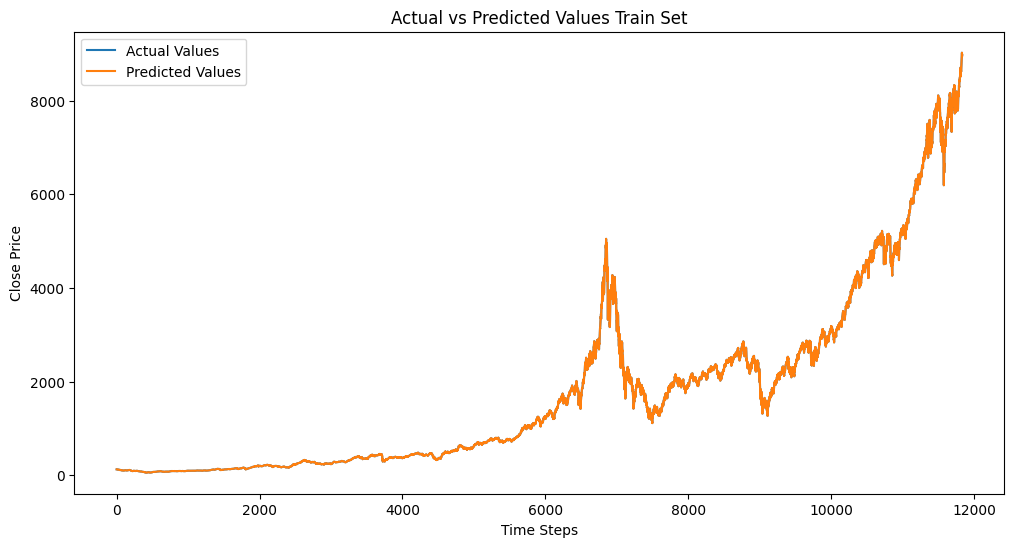

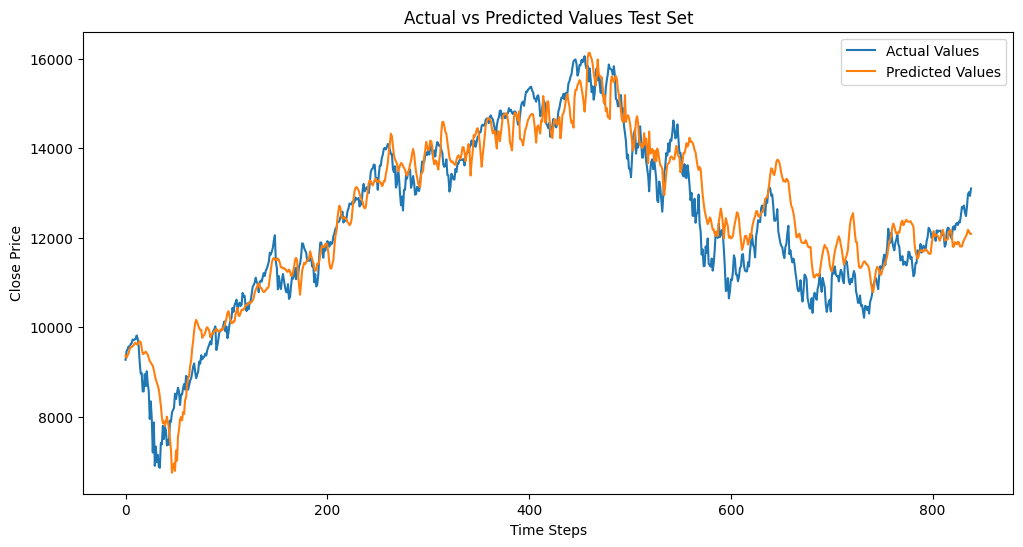

In [66]:
import matplotlib.pyplot as plt

y_test_pred = best_model.predict(X_test_seq)
y_train_pre = best_model.predict(X_train_seq)

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Actual vs Predicted Values' + title)
    plt.xlabel('Time Steps')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


plot_predictions(y_train_seq, y_train_seq, " Train Set")
plot_predictions(y_test_seq, y_test_pred, " Test Set")

In [68]:
model = tf.keras.models.load_model('best_model.keras')
model.summary()

/Users/tomaszkoczar/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 96)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,229 (1.85 MB)

 Trainable params: 161,409 (630.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 322,820 (1.23 MB)